In [ ]:
import os
import cv2
from augment_pictures import get_average_bounding_box, add_picture_to_picture

In [ ]:
import sys
sys.path.append(".")
VARIANTS = ["train", "test", "valid"]
TARGET_RESOLUTION = (640, 640)
OVERLAP = 0.0 # As a percentage
OUTPUT_FOLDER = "/notebooks/DL---detection-of-birds-in-drone-images/data/tiled_augmented_640_good_augment_yolo_data"
INPUT_FOLDER = "/notebooks/DL---detection-of-birds-in-drone-images/data/data_yolo_format"

# Create the output folders
for variant in VARIANTS:
    if not os.path.exists(os.path.join(OUTPUT_FOLDER, variant)):
        os.makedirs(os.path.join(OUTPUT_FOLDER, variant, "images"), exist_ok=True)
        os.makedirs(os.path.join(OUTPUT_FOLDER, variant, "labels"), exist_ok=True)

files = []
for variant in VARIANTS:
    for file in os.listdir(os.path.join(INPUT_FOLDER, variant, "images")):
        files.append(os.path.join(INPUT_FOLDER, variant, "images", file))


In [ ]:
import numpy as np


def gamma_correction(image, gamma=1.0):
    # Ensure gamma is a positive number
    if gamma <= 0:
        raise ValueError("Gamma should be greater than 0")

    # Build a lookup table mapping pixel values [0, 255] to their gamma-corrected values
    inv_gamma = 1.0 / gamma
    table = np.array([
        ((i / 255.0) ** inv_gamma) * 255
        for i in range(256)
    ]).astype("uint8")

    # Apply gamma correction using the lookup table
    return cv2.LUT(image, table)


def auto_gamma(image, target_brightness=0.5):
    """
    Automatically adjusts gamma to normalize image brightness.

    Gamma > 1 brightens the image, Gamma < 1 darkens the image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray) / 255.0

    # Prevent division by zero or extremely low brightness
    if brightness < 1e-3:
        gamma = 2.5  # Force strong brightening
    else:
        gamma = target_brightness / brightness

    gamma = np.clip(gamma, 0.3, 3.0)  # Clamp to reasonable range
    corrected = gamma_correction(image, gamma)
    return corrected, gamma


In [ ]:
len(os.listdir("/notebooks/DL---detection-of-birds-in-drone-images/data/tiled_augmented_yolo_data/train/images"))

In [ ]:

import math

all_new_tiles = {}
gammas = []

for file in files:
    img_tiles = []
    if ".ipynb_checkpoints" in file or ".DS_Store" in file:
        continue
    img = cv2.imread(file)

    h, w, channels = img.shape

    x_tile_step = TARGET_RESOLUTION[0] * (1-OVERLAP)
    y_tile_step = TARGET_RESOLUTION[1] * (1-OVERLAP)

    number_of_images_w = math.ceil(w / x_tile_step)
    number_of_images_h = math.ceil(h / y_tile_step)

    for y in range(number_of_images_h):
        for x in range(number_of_images_w):
            x_min = int(x * x_tile_step)
            x_max = int(min(x_min + TARGET_RESOLUTION[0], w))
            y_min = int(y * y_tile_step)
            y_max = int(min(y_min + TARGET_RESOLUTION[1], h))

            tile = img[y_min:y_max, x_min:x_max]
            tile_corrected, gamma = auto_gamma(tile)
            gammas.append((file, gamma))
            img_tiles.append({"w": w, "h": h, "x_min": x_min, "x_max": x_max, "y_min": y_min, "y_max": y_max, "tile": tile_corrected})

    all_new_tiles[file] = img_tiles

Een tile in 'train/images/DJI_0164.JPG' heeft een gamma van 0.3

In [ ]:
from typing import List
import re

skipped_tile_paths = []

class Label:
    def __init__(self, x_min, x_max, y_min, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max


def parse_labels(labels: List[str], original_w: int, original_h: int) -> List[Label]:
    parsed_labels = []
    for label in labels:
        coords = label.split(" ")[1:]

        width = float(coords[2])
        height = float(coords[3])

        x_min = float(coords[0]) - (width/2)
        y_min = float(coords[1]) - (height/2)
        x_max = x_min + width
        y_max = y_min + height

        parsed_labels.append(
            Label(
                x_min * original_w,
                x_max * original_w,
                y_min * original_h,
                y_max * original_h
            )
        )
    return parsed_labels

for original_path, tiles in all_new_tiles.items():
    label_file = original_path.replace("/images", "/labels")
    label_file = ".".join(label_file.split(".")[:-1]) + ".txt"
    
    average_rel_width, average_rel_height = get_average_bounding_box(label_file)
    # We must calculate the relative width of the tile, as the relative width is of the orignal file
    cropped_image_size_increase = 2 

    average_rel_width = average_rel_width * cropped_image_size_increase
    average_rel_height = average_rel_height * cropped_image_size_increase

    with open(label_file, "r") as f:
        parsed_labels = parse_labels(f.readlines(), tiles[0]["w"], tiles[0]["h"])

    last_folder_name = INPUT_FOLDER.split("/")[-1]
    search = re.search(rf"{last_folder_name}/(.*?)/images/", original_path)
    variant = search.group(1)
    
    relative_label_widths = []
    relative_label_heights = []

    
    for i, tile in enumerate(tiles):
        # Place tile image
        tile_img_file_name = ".".join(original_path.split("/")[-1].split(".")[:-1]) + "_tile-" + str(i) + ".png"
        tile_img_path = os.path.join(OUTPUT_FOLDER, variant, "images", tile_img_file_name)

        cv2.imwrite(tile_img_path, tile["tile"])

        # Figure out which labels of the labels of the original image are in the tile, and adapt the coordinates accordingly
        tile_labels = []
        for label_i, label in enumerate(parsed_labels):
            if (tile["x_min"] < label.x_min and tile["x_max"] > label.x_max and
                tile["y_min"] < label.y_min and tile["y_max"] > label.y_max):

                x_min = label.x_min - tile["x_min"]
                y_min = label.y_min - tile["y_min"]
                x_max = label.x_max - tile["x_min"]
                y_max = label.y_max - tile["y_min"]

                tile_width = tile["x_max"] - tile["x_min"]
                tile_height = tile["y_max"] - tile["y_min"]

                label_relative_width = (x_max - x_min) / tile_width
                label_relative_height = (y_max - y_min) / tile_height

                tile_labels.append(f"0 {x_min / tile_width + (label_relative_width / 2)} {y_min / tile_height + (label_relative_height / 2)} "
                                   f"{label_relative_width} "
                                   f"{label_relative_height}")
                
                relative_label_widths.append(label_relative_width)
                relative_label_heights.append(label_relative_height)

        tile_label_file_name = tile_img_file_name.replace(".png", ".txt")
        tile_label_path = os.path.join(OUTPUT_FOLDER, variant, "labels", tile_label_file_name)
        with open(tile_label_path, "w") as f:
            f.write("\n".join(tile_labels))
        
        if relative_label_widths:
            average_rel_width = sum(relative_label_widths)/len(relative_label_widths)
            average_rel_width /= 2
            average_rel_height = sum(relative_label_heights)/len(relative_label_heights)
            average_rel_height /= 2
        # only for tiles in the train set, do augment the pictures with synthetic birds
        # This is most likely due to an issue of the src type of the image
        if "train" in tile_img_path:
            # When there is no existing bird in the picture we skip the picture and we do not add new birds in the picture
            if average_rel_width == 0:
                continue
            add_picture_to_picture(tile_img_path, tile_label_path, average_rel_width, average_rel_height)
            add_picture_to_picture(tile_img_path, tile_label_path, average_rel_width, average_rel_height)


In [6]:
print("we skipped ", len(skipped_tile_paths), "tiles because they couldn't be added")

we skipped  0 tiles because they couldn't be added


# Visualization
For testing purposes

The last bounding box that is added is made green. This works in almost all cases. Except when the bounding box is not added because in the previous step there was an error with the image. I could't figure out what the problem was so I just skipped it. But there are 102 tiles that do not have had added a bonto them because of that. 

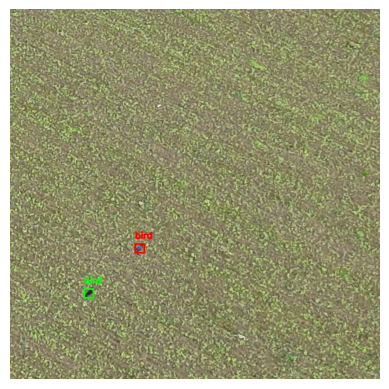

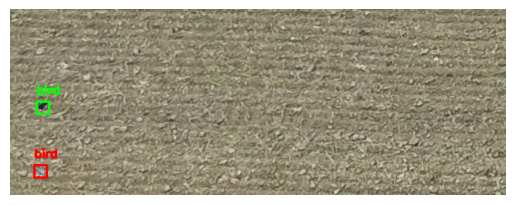

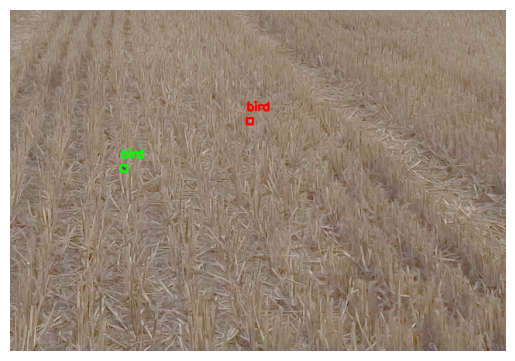

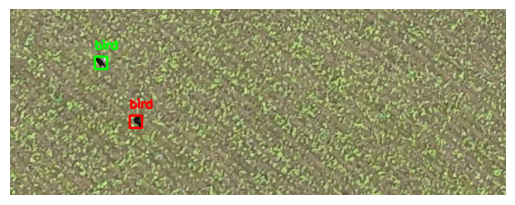

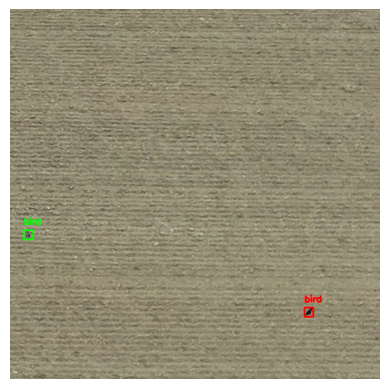

In [19]:
import cv2
import matplotlib.pyplot as plt

def load_yolo_labels(label_path):
    boxes = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) != 5:
                continue  # skip malformed lines
            class_id, x_center, y_center, width, height = map(float, parts)
            boxes.append((int(class_id), x_center, y_center, width, height))
    return boxes

def draw_yolo_boxes(image_path, label_path, class_names=None):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    boxes = load_yolo_labels(label_path)
    for index, (class_id, x_center, y_center, width, height) in enumerate(boxes):
        # Convert normalized YOLO coords to pixel coords
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)
        
        # if the box is the last box, then the color becomes green
        # the last box is the added box
        if index == len(boxes)-1:
            color = (0, 255, 0)  # Red box
        else:
            color = (255, 0, 0)  # Red box
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

        label = str(class_id)
        if class_names and class_id < len(class_names):
            label = class_names[class_id]

        cv2.putText(image, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example usage:

folder_path = OUTPUT_FOLDER
import random
image_name = os.path.splitext(random.choice(os.listdir(f'{OUTPUT_FOLDER}/train/labels')))[0]
image_path = f'{OUTPUT_FOLDER}/train/images/{image_name}.png'
label_path = f'{OUTPUT_FOLDER}/train/labels/{image_name}.txt'
class_names = ['bird']  # optional
draw_yolo_boxes(image_path, label_path, class_names)

image_name = os.path.splitext(random.choice(os.listdir(f'{OUTPUT_FOLDER}/train/labels')))[0]
image_path = f'{OUTPUT_FOLDER}/train/images/{image_name}.png'
label_path = f'{OUTPUT_FOLDER}/train/labels/{image_name}.txt'
class_names = ['bird']  # optional
draw_yolo_boxes(image_path, label_path, class_names)


image_name = os.path.splitext(random.choice(os.listdir(f'{OUTPUT_FOLDER}/train/labels')))[0]
image_path = f'{OUTPUT_FOLDER}/train/images/{image_name}.png'
label_path = f'{OUTPUT_FOLDER}/train/labels/{image_name}.txt'
class_names = ['bird']  # optional
draw_yolo_boxes(image_path, label_path, class_names)


image_name = os.path.splitext(random.choice(os.listdir(f'{OUTPUT_FOLDER}/train/labels')))[0]
image_path = f'{OUTPUT_FOLDER}/train/images/{image_name}.png'
label_path = f'{OUTPUT_FOLDER}/train/labels/{image_name}.txt'
class_names = ['bird']  # optional
draw_yolo_boxes(image_path, label_path, class_names)


image_name = os.path.splitext(random.choice(os.listdir(f'{OUTPUT_FOLDER}/train/labels')))[0]
image_path = f'{OUTPUT_FOLDER}/train/images/{image_name}.png'
label_path = f'{OUTPUT_FOLDER}/train/labels/{image_name}.txt'
class_names = ['bird']  # optional

image_name = os.path.splitext(random.choice(os.listdir(f'{OUTPUT_FOLDER}/train/labels')))[0]
image_path = f'{OUTPUT_FOLDER}/train/images/{image_name}.png'
label_path = f'{OUTPUT_FOLDER}/train/labels/{image_name}.txt'
class_names = ['bird']  # optional

draw_yolo_boxes(image_path, label_path, class_names)
